In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from math import erfc, sqrt, pi, exp
from torch.optim import Adam
from torch.autograd import grad
from torch.autograd.functional import hessian
import matplotlib.pyplot as plt
import time
import pandas as pd

#### static energy

In [3]:
# ## 1. Simulation constants & helper functions
a_m   = 8.031          # nm   moiré lattice constant, supercell length, from paper (the lattice mismatch between WSe2 and WS2)
V0    = 15.0         # meV  from paper
eps_r = 5.0         # dielectric constant in paper
e2_4pieps0 = 14.399645  # meV·nm (|e|²/4πϵ0)
hbar2_over_2m = 108.857 # meV·nm² in paper
phi = np.pi/4   # phase of the moiré potential from paper
n_sup = 3            # 3×3 super-cell
N_e   = 6               # # electrons (= # occupied orbitals)
cut   = 2  # |G|≤cut·|g| # cutoff for the plane-wave basis (G vectors) in the Hamiltonian

# --- Ewald parameters (renamed) ---
ew_alpha = 0.35      # nm⁻²  (splitting)
r_cut    = 2.5       # real-space cutoff in L units
k_cut    = 5         # k-space cutoff in 2π/L units
L     = n_sup * a_m  # nm   PBC box length used in Ewald

def a_vectors(a_m):
    """Generates the 3 shortest moiré reciprocal vectors G_1,2,3, 60° apart, six-fold symmetry"""
    a1 = a_m * np.array([1.0,                0.0           ])
    a2 = a_m * np.array([0.5,  np.sqrt(3.0) / 2.0          ])
    a3 = -(a1 + a2)        # optional third vector (120° w.r.t. a1)
    return [a1, a2, a3]    # same interface style as your b_vectors()

def b_vectors(a_m):
    """from paper: g_j = (4*pi / sqrt(3) / a_m) * [cos(2*pi*j/3), sin(2*pi*j/3)], for j=1,2,3"""
    g_list = []
    prefac = 4 * np.pi / (np.sqrt(3) * a_m)
    for j in range(1, 4):  # j = 1, 2, 3
        angle = 2 * np.pi * j / 3
        g = prefac * np.array([np.cos(angle), np.sin(angle)])
        g_list.append(g)
    # print("g list", g_list)
    return g_list  # returns [g1, g2, g3]
# real-space vectors of an n×n super-cell   (n = 3 here since we have 3x3 supercell)

def supercell_vectors(n, a_m):
    a1, a2 = a_vectors(a_m)
    return n*a1, n*a2

def moire_potential(r, a_m = a_m, V0 = V0, phi = phi):
    """ V(r) = -2*V0*sum_{j=1}^{3} cos(g_j · r + phi)where g_j are 3 reciprocal lattice vectors (from paper)."""
    G = np.array(b_vectors(a_m))  # Get the three reciprocal vectors, shape (3,2)
    phase = np.dot(r, G.T) + phi  # r @ G.T + phi
    one_electron_moire = -2 * V0 * np.sum(np.cos(phase), axis=-1)
    return np.sum(one_electron_moire)

# ---------- Ewald helpers (using ew_alpha) ----------
def pairwise_real_space(R, alpha=ew_alpha, r_lim=r_cut, L=L):
    """ Short‐range (real‐space) Ewald sum (equation A6 from the paper):
    E_real = ½ ∑_{i≠j} ∑_L erfc(√α·r_{ij}^L) / r_{ij}^L.,
    where α = 1/(4η²), and r_{ij}^L = |r_i - r_j + L|"""
    N, E = len(R), 0.0 #N:number particles
    maxn = int(np.ceil(r_lim)) # summing over neighbor cells from -max_n to +max_n
    for i in range(N):
        for j in range(i+1,N): # loop over ½ ∑_{i≠j}
            for nx in range(-maxn,maxn+1): #loop over n_x n_y
                for ny in range(-maxn,maxn+1):
                    dr = R[i]-R[j]+np.array([nx,ny])*L # dr = r_i - r_j + n·L
                    r  = np.linalg.norm(dr) # r = |dr|
                    if r<1e-9 or r>r_lim*L: continue # Skip self‐interaction (r≈0) or beyond cutoff r_lim·L
                    E += erfc(sqrt(alpha)*r)/r # α = 1/(4η²) we choose
    return E

def structure_factor(R,k):    # Σ e^{ik·r}
    """Structure factor S(k) = Σ e^{ik·r} (sum over all particles)"""
    phase = R @ k
    return np.sum(np.cos(phase))+1j*np.sum(np.sin(phase))

def reciprocal_space(R, alpha=ew_alpha, k_lim=k_cut, L=L):
    """ Long‐range (reciprocal‐space) Ewald sum (equation A7 and A10 from the paper):
    E_recip = (π/V) ∑_{k≠0} [ e^{-k²/(4α)} / k² ] |S(k)|²
    with V = L² in 2D, fast convergence."""
    area, k0 = L*L, 2*pi/L
    E=0.0
    # 2) Sum over discrete wavevectors q = (m_x, m_y)·(2π/L), the paper has ∑_{q≠0};
    # here we loop m_x, m_y ∈ [−k_lim,…,+k_lim]
    for mx in range(-k_lim,k_lim+1):
        for my in range(-k_lim,k_lim+1):
            if mx==0 and my==0: continue # skip the q = 0 term
            k = np.array([mx,my])*k0 # q_vec = (m_x, m_y)·(2π/L)
            k2 = k@k # q² = |q_vec|² = q_x² + q_y²
            E += exp(-k2/(4*alpha))*abs(structure_factor(R,k))**2 / k2 # factor e^{–q²/(4α)} # e^{-q²/(4α)}/q² · |S(q)|²
    return (pi/area)*E

def self_energy(N, alpha=ew_alpha):
    """ (equation A12 from the paper, Madelung constant) Self‐interaction correction: E_self = - ∑_i (√α / √π) · q_i²
    Here q_i are unit charges, so E_self = -N·(√α/√π)."""
    return -sqrt(alpha/pi)*N

# ξ_M : configuration-independent Madelung constant
def madelung_offset(alpha=ew_alpha,                 # α = 1/(4η²)
                    r_lim=r_cut, k_lim=k_cut, L=L):
    """ Compute ξ_M in Eq. (A12) Returns a scalar (dimensionless).  Multiply by e²/4πϵ₀ϵ_r later."""
    eta   = 0.5 / np.sqrt(alpha)     # because α = 1/(4η²)
    area  = L * L
    k0    = 2.0 * np.pi / L
    # ---- Real-space images   Σ_{L≠0} erfc(|L|/2η)/|L|
    rsum = 0.0
    maxn = int(np.ceil(r_lim))
    for nx in range(-maxn, maxn + 1):
        for ny in range(-maxn, maxn + 1):
            if nx == 0 and ny == 0:
                continue
            Rvec = np.array([nx, ny]) * L
            R    = np.linalg.norm(Rvec)
            if R > r_lim * L:
                continue
            rsum += erfc(R / (2.0 * eta)) / R
    # ---- Reciprocal-space images   (2π/Area) Σ_{G≠0} e^{−η²G²}/G
    ksum = 0.0
    for mx in range(-k_lim, k_lim + 1):
        for my in range(-k_lim, k_lim + 1):
            if mx == 0 and my == 0:
                continue
            Gvec = np.array([mx, my]) * k0
            G    = np.linalg.norm(Gvec)
            ksum += np.exp(-(eta * G) ** 2) / G
    ksum *= 2.0 * np.pi / area
    xi0_L = 1.0 / (eta * np.sqrt(np.pi))     # ---- ξ^L_0 term   1 / (η √π)
    return rsum + ksum - xi0_L     # ---- ξ_M (Eq. A12)

ξ_M = madelung_offset() * e2_4pieps0 / eps_r # compute once and store — units:   meV

def coulomb_ewald_2D(R):
    """
    Full 2-D Ewald energy for the set of positions R (shape (N,2)).
    Now includes ½ Σ_b ξ_M  so the result matches Eq. (A11) exactly.
    E_total = (e²/(4πϵ₀ ε_r))·( E_real + E_recip + E_self )
    """
    N  = len(R)
    # position-dependent part (your original implementation)
    E_config = (pairwise_real_space(R) +
                reciprocal_space(R)   +
                self_energy(N)) * e2_4pieps0 / eps_r
    # constant Madelung shift
    return E_config + 0.5 * N * ξ_M

def energy_static(R):
    """V_ext + V_ee  (independent of Ψ)."""
    return moire_potential(R) + coulomb_ewald_2D(R)

# energy_static(np.random.rand(6,2))
# energy_moire = energy_static

#### NN

In [4]:
class FeedForwardLayer(nn.Module):
    """ A single feed-forward layer with a tanh activation function.
        The input is added to the output of the layer. """

    def __init__(self, L: int) -> None: # L: layer of width d_L
        super().__init__()
        self.Wl_1p = nn.Linear(L, L)   # W^(l+1) h^l + b^(l+1)
        self.tanh = nn.Tanh()       # (nonlinear) hyperbolic tangent activation function

    def forward(self, hl: torch.Tensor) -> torch.Tensor:
        return hl + self.tanh(self.Wl_1p(hl))  # input should be of shape (N, L): h^l + tanh( W^(l+1) h^l + b^(l+1) )

class SlaterNet(nn.Module):
    # def __init__(self, a: float, N: int, L: int = 4, num_layers: int = 3) -> None: # a: lattice constant
    def __init__(self, a, N, L = 64, num_layers = 3) -> None:  # L: layer of width d_L; a: lattice constant

        super().__init__()
        self.N = N
        self.L = L
        self.a = a
        self.num_layers = num_layers

        G_vectors = torch.from_numpy(np.array(b_vectors(a))).float()
        self.register_buffer('G1_T', G_vectors[0].unsqueeze(-1))
        self.register_buffer('G2_T', G_vectors[1].unsqueeze(-1)) # register_buffer: G vectors as part of the model, but not as a trainable parameter.

        # input embedding matrix: projects 4 features to L-dim
        self.W_0 = nn.Linear(4, L, bias=False)
        self.MLP_layers = nn.ModuleList( # create a list of MLP layers
            [FeedForwardLayer(L) for _ in range(num_layers)]
        )

        # matrix to hold the projection vectors (complex projectors for orbital) they're trainable parameters
        # w_2j and w_2j+1 (one for real one for complex) for j = 0, ... N-1 (6 electrons)
        self.complex_proj = nn.Parameter(
            torch.complex(real=torch.randn(L, N), imag=torch.randn(L, N))
        )
        # self.denominator = math.sqrt(math.factorial(N))

    def forward(self, R: torch.Tensor) -> torch.Tensor:  # R should be of shape (N, 2)

        G1_R = torch.matmul(R, self.G1_T)         # compute the periodic features
        G2_R = torch.matmul(R, self.G2_T)
        features_R = torch.cat(
            (torch.sin(G1_R), torch.sin(G2_R), torch.cos(G1_R), torch.cos(G2_R)), dim=1
        ) # shape (N, 4)

        # embed in higher_dimensional space to get h^0
        h = self.W_0(features_R)

        # pass through MLP layers
        for layer in self.MLP_layers:
            h = layer(h)

        # slater matxix
        WF_matrix = torch.matmul(h.to(torch.complex64), self.complex_proj)
        determinant = torch.linalg.det(WF_matrix)
        # result = determinant/self.denominator
        return determinant

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Checks if you have a GPU (CUDA). If yes, run on GPU for speed; otherwise, run on CPU

#### VMC

In [5]:
# slow method
def complex_grad(outputs, inputs, grad_outputs=None): # output is ψ, input is R
    # Takes the each part of psi and computes its gradient w.r.t. inputs using PyTorch’s autograd.grad
    grad_real = torch.autograd.grad(outputs.real, inputs, grad_outputs=grad_outputs, create_graph=True, allow_unused=True)[0]
    grad_imag = torch.autograd.grad(outputs.imag, inputs, grad_outputs=grad_outputs, create_graph=True, allow_unused=True)[0]
    grad = None
    if grad_real is not None and grad_imag is not None:
        grad = grad_real + 1j * grad_imag
    elif grad_real is not None:
        grad = grad_real
    elif grad_imag is not None:
        grad = 1j * grad_imag
    else:
        grad = torch.zeros_like(inputs)
    return grad # Return the (possibly complex-valued) gradient

def compute_laplacian_complex(psi, R):
    """
    Compute ∇²Ψ(R) for a complex Ψ using two successive calls
    to complex_grad (which handles complex outputs).
    """
    # first derivatives ∂Ψ/∂R_{i,d}, shape (N_e, 2), complex
    grads = complex_grad(psi, R)
    lap = 0
    N, D = R.shape

    # loop electrons i and dims d
    for i in range(N):
        for d in range(D):
            # grab the scalar ∂Ψ/∂R_{i,d}
            first_deriv = grads[i, d]

            # now take its gradient w.r.t. R
            # this is ∂²Ψ / (∂R_{i,d} ∂R_{j,k}) for all j,k
            grads2 = complex_grad(first_deriv, R)

            # we only want the diagonal piece ∂²Ψ/∂R_{i,d}²
            lap += grads2[i, d]

    return lap

# def local_energy(net, R):
#     """ """
#     R = R.clone().detach().to(device).requires_grad_(True)
#     psi = net(R)
#     lap_psi = compute_laplacian_complex(psi, R)
#     kin_complex = -hbar2_over_2m * (lap_psi / psi)
#     kin = kin_complex.real
#     V_np = energy_static(R.detach().cpu().numpy())
#     V = torch.tensor(V_np, device=device, dtype=kin.dtype)
#     return kin + V

# faster way:
def compute_laplacian_hessian(net, R):
    """
    Compute ∇²ψ(R) by taking the trace of the full Hessian
    of ψ's real and imag parts.
    """
    R = R.clone().detach().to(device).requires_grad_(True)

    # Define helper functions that output a real scalar:
    def fn_real(X):
        return net(X).real

    def fn_imag(X):
        return net(X).imag

    # Each Hessian has shape (N, D, N, D). Flatten to (ND, ND) for trace.
    H_real = torch.autograd.functional.hessian(fn_real, R)  # (N, D, N, D)
    H_imag = torch.autograd.functional.hessian(fn_imag, R)  # (N, D, N, D)

    N, D = R.shape
    H_real_flat = H_real.reshape(N*D, N*D)
    H_imag_flat = H_imag.reshape(N*D, N*D)

    lap_real = torch.trace(H_real_flat)
    lap_imag = torch.trace(H_imag_flat)
    return lap_real + 1j * lap_imag

# namely, local_energy_hessian
def local_energy(net, R):
    """ Local energy using the Hessian‐based Laplacian. """

    R = R.clone().detach().to(device).requires_grad_(True)
    psi = net(R)  # complex scalar

    # The only change: use compute_laplacian_hessian instead of nested loops.
    lap_psi = compute_laplacian_hessian(net, R)  # complex

    denominator = psi if torch.abs(psi) > 1e-12 else psi + 1e-12  # avoid division by zero
    kin = -(hbar2_over_2m * (lap_psi / denominator)).real    
    # kin = -(hbar2_over_2m * (lap_psi / psi)).real    

    if torch.isnan(kin):
        print(f"[local_energy] NaN detected in kinetic: psi={psi}, lap_psi={lap_psi}, kin={kin}")

    V_np = energy_static(R.detach().cpu().numpy())
    V = torch.tensor(V_np, device=device, dtype=kin.dtype)
    total_energy = kin + V
    return total_energy

def mcmc_sampler(net, R_init, n_steps=200, step_size=0.1):
    """ Metropolis–Hastings sampler to draw samples ~ |Ψ|².
    Inputs:
      - net: SlaterNet model
      - R_init: torch.Tensor (N_e,2), starting positions
      - n_steps: number of MCMC steps
      - step_size: Gaussian proposal standard deviation
    Returns:
      - samples: list of torch.Tensor configurations (one per step)"""

    R = R_init.clone().to(device)
    psi_sq = torch.abs(net(R))**2     # Compute initial |Ψ|²
    samples = []
    for _ in range(n_steps):
        for i in range(R.shape[0]):     # propose move for each electron
            R_prop = R.clone()
            R_prop[i] += step_size * torch.randn_like(R[i])             # Gaussian random displacement
            R_prop[i] = R_prop[i] % L       # Enforce PBC in a box of length L
            psi_sq_prop = torch.abs(net(R_prop))**2       # evalualte |Ψ|² at the proposed R
            if (psi_sq_prop / (psi_sq + 1e-12)) > torch.rand(1, device=device):
                R[i] = R_prop[i]
                psi_sq = psi_sq_prop
        samples.append(R.clone())
    return samples




# show the plot of <E> vs. iteration, same physics as train_vmc
def train_vmc_and_return_history(net,
                                 n_iter=200,
                                 n_walkers=8,
                                 n_steps=200,
                                 step_size=0.1):
    """
    Exactly the same as train_vmc_with_plot, but it does NOT do any plotting.
    Instead it records ⟨E⟩ each iteration and returns that list.
    """
    η_0 = 1e-4    # initial learning rate
    t0  = 1e5     # decay “time constant”
    rho = 5.0     # clipping threshold

    optimizer = Adam(net.parameters(), lr=η_0)
    walkers = [L * torch.rand(net.N, 2, device=device) for _ in range(n_walkers)]

    energy_history = []

    for it in range(1, n_iter + 1):
        # update lr
        lr_t = η_0 * (1 + it / t0) ** -1
        for pg in optimizer.param_groups:
            pg['lr'] = lr_t

        batch_E_full  = []
        batch_E_clip  = []
        batch_logpsi  = []
        new_walkers   = []

        for w in walkers:
            samples = mcmc_sampler(net, w, n_steps, step_size)
            new_walkers.append(samples[-1])
            for R in samples:
                Eloc_full = local_energy(net, R)
                Eloc_clip = torch.clamp(Eloc_full, -rho, +rho)

                batch_E_full.append(Eloc_full)
                batch_E_clip.append(Eloc_clip)
                batch_logpsi.append(torch.log(torch.abs(net(R)) + 1e-12))

        E_full = torch.stack(batch_E_full)
        E_clip = torch.stack(batch_E_clip)
        logpsi = torch.stack(batch_logpsi)

        E_mean_full = E_full.mean()
        energy_history.append(E_mean_full.item())

        E_mean_clip = E_clip.mean().detach()
        loss = torch.mean((E_clip - E_mean_clip) * logpsi)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        walkers = new_walkers
        print(f"Iter {it:3d}/{n_iter:3d} | <E> = {E_mean_full.item():.6f} | lr = {lr_t:.3e}")

    return energy_history

# the one without timer (exactly same physics with the timer version)
def train_vmc(net,
              n_iter=200,
              n_walkers=8,
              n_steps=200,
              step_size=0.1):
    """ VMC training with a decaying learning rate: η(t) = η_0 * (1 + t/t0)^(-1) （page 13）"""

    η_0 = 1e-4    # initial learning rate (Table II)
    t0  = 1e5     # decay “time constant”
    rho = 5.0     # clipping threshold for local energy

    optimizer = Adam(net.parameters(), lr=η_0)
    # Adam will perform parameter updates θ ← θ – η·∇_θ L

    # Each walker is one configuration R of N_e electrons in 2D, drawn uniformly in [0, L)^2
    walkers = [L * torch.rand(net.N, 2, device=device) for _ in range(n_walkers)]

    # Main VMC loop ──────────────────────────────────────────────────────────────────
    for it in range(1, n_iter + 1):
        # — Update the learning rate —
        lr_t = η_0 * (1 + it / t0) ** -1
        for pg in optimizer.param_groups:
            pg['lr'] = lr_t

        # Prepare lists to collect data over all walkers & steps
        batch_E_full = []   # unclipped E_loc, for logging true ⟨E⟩
        batch_E_clip = []   # clipped E_loc, for building the loss
        batch_logpsi = []   # ln|Ψ(R)|, the “score‐function” term, will be used in loss function
        new_walkers  = []   # to hold final config of each walker


        # t0_sampling = time.time()

        for w in walkers:
            samples = mcmc_sampler(net, w, n_steps, step_size) # mcmc_sampler we previously wrote
            new_walkers.append(samples[-1])
            for R in samples:
                # 1) compute full local energy
                Eloc_full = local_energy(net, R)

                # 2) clip for stability in the loss
                Eloc_clip = torch.clamp(Eloc_full, -rho, +rho)

                batch_E_full.append(Eloc_full)
                batch_E_clip.append(Eloc_clip)
                batch_logpsi.append(torch.log(torch.abs(net(R)) + 1e-12))

        # stack into tensors
        E_full      = torch.stack(batch_E_full)
        E_clip      = torch.stack(batch_E_clip)
        logpsi      = torch.stack(batch_logpsi)

        # true mean energy (for reporting)
        E_mean_full = E_full.mean()

        # clipped mean energy (for loss)
        E_mean_clip = E_clip.mean().detach()

        # VMC loss uses clipped energies
        loss = torch.mean((E_clip - E_mean_clip) * logpsi)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        walkers = new_walkers
        print(f'Iter {it:3d}/{n_iter:3d} | <E> = {E_mean_full.item():.6f} meV | lr = {lr_t:.3e}')

    return net

# with timer version (exactly same physics with previous code)
def train_vmc_timer(net, n_iter=200, n_walkers=8, n_steps=200, step_size=0.1):
    η_0 = 1e-4
    t0  = 1e5
    rho = 5.0
    optimizer = Adam(net.parameters(), lr=η_0)
    walkers = [L * torch.rand(net.N, 2, device=device) for _ in range(n_walkers)]

    for it in range(1, n_iter + 1):
        iter_start = time.time()

        lr_t = η_0 * (1 + it / t0) ** -1
        for pg in optimizer.param_groups:
            pg['lr'] = lr_t

        batch_E_full, batch_E_clip, batch_logpsi, new_walkers = [], [], [], []
        
        # --- Time the sampling ---
        t0_sampling = time.time()
        for w in walkers:
            samples = mcmc_sampler(net, w, n_steps, step_size)
            new_walkers.append(samples[-1])
            for R in samples:
                batch_E_full.append(R)  # we'll time local_energy below
        t1_sampling = time.time()

        # --- Time the local energy computation ---
        t0_localE = time.time()
        Elocs_full, Elocs_clip, logpsis = [], [], []
        for R in batch_E_full:
            Eloc_full = local_energy(net, R)
            Eloc_clip = torch.clamp(Eloc_full, -rho, +rho)
            Elocs_full.append(Eloc_full)
            Elocs_clip.append(Eloc_clip)
            logpsis.append(torch.log(torch.abs(net(R)) + 1e-12))
        t1_localE = time.time()

        # --- Stack tensors (usually fast) ---
        t0_stack = time.time()
        E_full = torch.stack(Elocs_full)
        E_clip = torch.stack(Elocs_clip)
        logpsi = torch.stack(logpsis)
        t1_stack = time.time()

        # --- Loss and optimizer step ---
        t0_opt = time.time()
        E_mean_full = E_full.mean()
        E_mean_clip = E_clip.mean().detach()
        loss = torch.mean((E_clip - E_mean_clip) * logpsi)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        t1_opt = time.time()

        walkers = new_walkers

        iter_end = time.time()

        print(f'Iter {it:3d}/{n_iter:3d} | <E> = {E_mean_full.item():.6f} meV | lr = {lr_t:.3e}')
        print(f'  Sampling time:       {t1_sampling-t0_sampling:.2f} s')
        print(f'  Local energy time:   {t1_localE-t0_localE:.2f} s')
        print(f'  Stack time:          {t1_stack-t0_stack:.2f} s')
        print(f'  Optimizer step time: {t1_opt-t0_opt:.2f} s')
        print(f'  Total iteration:     {iter_end-iter_start:.2f} s\n')
    return net

#### train

In [6]:
# train to show time
net = SlaterNet(a_m, N_e, L=64, num_layers=3).to(device) #-----number layers: 3; Perceptron dim: 64
trained_net = train_vmc_timer(net,
                        n_iter=5, # paper says 150000 ------- Training iterations
                        n_walkers=16,
                        n_steps=256,
                        step_size=0.05,
                        )

# ------n_walkers * n_steps = 4096 (MCMC batch size) namely gather 4096 (𝑅,𝐸_loc, lnΨ) where
# “n_walkers”：how many independent MCMC chains we run in parallel
# “n_steps”: how many successive moves each walker makes

Iter   1/  5 | <E> = 741.481628 meV | lr = 1.000e-04
  Sampling time:       5.12 s
  Local energy time:   175.58 s
  Stack time:          0.03 s
  Optimizer step time: 5.22 s
  Total iteration:     185.95 s



KeyboardInterrupt: 

In [34]:
# train to save and plot results
net = SlaterNet(a_m, N_e, L=64, num_layers=3).to(device) #-----number layers: 3; Perceptron dim: 64
trained_net = train_vmc_and_return_history(net,
                        n_iter=50, # paper says 150000 ------- Training iterations
                        n_walkers=16,
                        n_steps=256,
                        step_size=0.05,
                        )

Iter   1/ 50 | <E> = 841.543152 | lr = 1.000e-04
Iter   2/ 50 | <E> = 780.514648 | lr = 1.000e-04
Iter   3/ 50 | <E> = 742.006836 | lr = 1.000e-04
Iter   4/ 50 | <E> = 752.184265 | lr = 1.000e-04
Iter   5/ 50 | <E> = 729.494995 | lr = 1.000e-04
Iter   6/ 50 | <E> = 707.762146 | lr = 9.999e-05
Iter   7/ 50 | <E> = 733.594116 | lr = 9.999e-05
Iter   8/ 50 | <E> = 677.083923 | lr = 9.999e-05
Iter   9/ 50 | <E> = 709.078308 | lr = 9.999e-05
Iter  10/ 50 | <E> = 712.945557 | lr = 9.999e-05
Iter  11/ 50 | <E> = 727.023254 | lr = 9.999e-05
Iter  12/ 50 | <E> = 735.682007 | lr = 9.999e-05
Iter  13/ 50 | <E> = 727.723999 | lr = 9.999e-05
Iter  14/ 50 | <E> = 776.721497 | lr = 9.999e-05
Iter  15/ 50 | <E> = 758.001831 | lr = 9.999e-05
Iter  16/ 50 | <E> = 739.938232 | lr = 9.998e-05
Iter  17/ 50 | <E> = 742.375854 | lr = 9.998e-05
Iter  18/ 50 | <E> = 738.279114 | lr = 9.998e-05
Iter  19/ 50 | <E> = 747.847290 | lr = 9.998e-05
Iter  20/ 50 | <E> = 717.343079 | lr = 9.998e-05
Iter  21/ 50 | <E> =

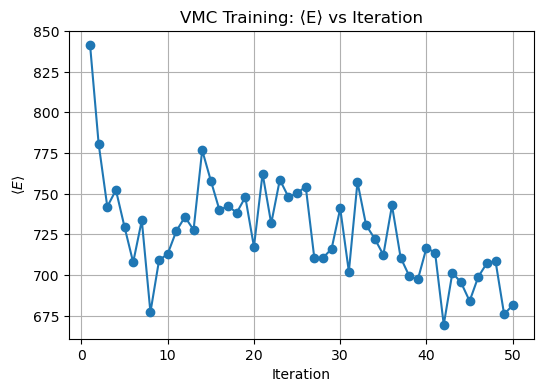

In [36]:
# Convert to a DataFrame and save:
df = pd.DataFrame({
    'iteration': list(range(1, len(trained_net) + 1)),
    'energy': trained_net
})

# df.to_csv('vmc_energy_history.csv', index=False)
# print("Saved energy history to vmc_energy_history.csv")

# # If you later want to re‐plot without re‐training, just reload:
# df = pd.read_csv('vmc_energy_history.csv')


plt.figure(figsize=(6,4))
plt.plot(df['iteration'], df['energy'], marker='o')
plt.xlabel('Iteration')
plt.ylabel(r'$\langle E \rangle$')
plt.title('VMC Training: ⟨E⟩ vs Iteration')
plt.grid(True)
plt.show()

#### check

some of the following codes are based on the slow way to compute the energy, but both the same physics

In [12]:
net = SlaterNet(a_m, N_e, L=64, num_layers=3).to(device) #-----number layers: 3; Perceptron dim: 64
R = torch.rand(N_e, 2, device=device, requires_grad=True) * (n_sup * a_m)
print("R: ", R)
psi = net(R)
print("psi: ", psi)

R:  tensor([[17.0733, 11.1724],
        [10.8718, 17.3538],
        [19.2847, 18.1188],
        [15.5732, 22.7232],
        [ 6.7079, 17.3667],
        [24.0130,  9.5571]], grad_fn=<MulBackward0>)
psi:  tensor(2808.7554-2686.7554j, grad_fn=<LinalgDetBackward0>)


In [13]:
grad = complex_grad(psi, R)
print("\ncomplex_grad output:", grad) # in the result, each row is ∂Ψ/∂x_i and i is electron index; each row has two complex values, since each x_i has two components x and y
laplacian = compute_laplacian_complex(psi, R)
print("\ncompute_laplacian_complex output:", laplacian)


complex_grad output: tensor([[-6928.4478+1409.1531j, -6289.9722+2339.9099j],
        [ 1637.1064-2087.0652j, -8266.1934+8854.1191j],
        [ 6059.0625-273.1194j, 14437.2275-4521.2671j],
        [ 5427.0132-1147.3513j,  6058.9312-2984.3027j],
        [ -663.4731-2019.7808j, -4055.9932-464.5109j],
        [-2855.9058+599.2159j, -1625.1329-3200.8027j]], grad_fn=<AddBackward0>)

compute_laplacian_complex output: tensor(-24438.1562+26923.8008j, grad_fn=<AddBackward0>)


In [14]:
E_loc = local_energy(net, R)
print("\nlocal_energy output:", E_loc)


local_energy output: tensor(1120.1459, grad_fn=<AddBackward0>)


In [ ]:
# check by computing KE and Potential seperately and summing:
psi = net(R)
lap_psi = compute_laplacian_complex(psi, R)
kin_complex = -hbar2_over_2m * (lap_psi / psi)
kin = kin_complex.real
print("Kinetic energy computed separately:      ", kin.item())

# --- Potential energy part
R_np = R.detach().cpu().numpy()
V_np = energy_static(R_np)
print("Potential energy computed separately:    ", V_np)

# --- Check if sum matches
total_manual = kin.item() + V_np
print("Sum of kinetic and potential energy:     ", total_manual)

if np.allclose(E_loc.item(), total_manual, atol=1e-5):
    print("PASS: local_energy matches manual sum!")
else:
    print("FAIL: Values differ!")
    print("Difference:", abs(E_loc.item() - total_manual))

Kinetic energy computed separately:       1015.8019409179688
Potential energy computed separately:     104.34387611496133
Sum of kinetic and potential energy:      1120.1458170329302
PASS: local_energy matches manual sum!


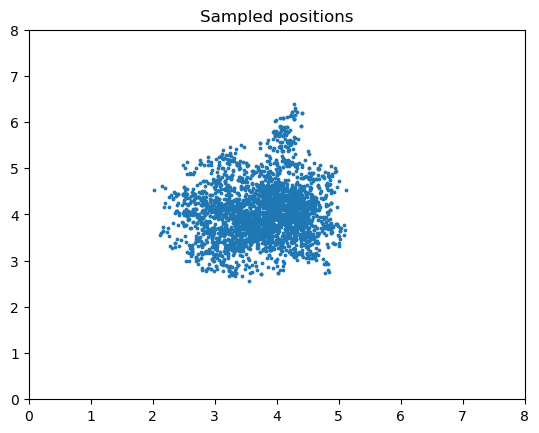

In [ ]:
# Simple Gaussian test net for mcmc_sampler function, for N_e=6
class SimpleGaussianNet(torch.nn.Module):
    def __init__(self, L):
        super().__init__()
        self.center = torch.tensor([L/2, L/2], dtype=torch.float32)

    def forward(self, R):
        distsq = ((R - self.center) ** 2).sum(-1)
        return torch.exp(-0.5 * distsq.sum())
N_e = N_e
L_test = 8
n_steps = 500
step_size = 0.1
net = SimpleGaussianNet(L_test)
R_init = torch.ones(N_e, 2) * (L_test / 2)  # Start at the center
samples = mcmc_sampler(net, R_init, n_steps=n_steps, step_size=step_size)
positions = torch.stack(samples).cpu().numpy().reshape(-1, 2)
plt.scatter(positions[:,0], positions[:,1], s=3)
plt.xlim(0, L_test)
plt.ylim(0, L_test)
plt.title('Sampled positions')
plt.show()


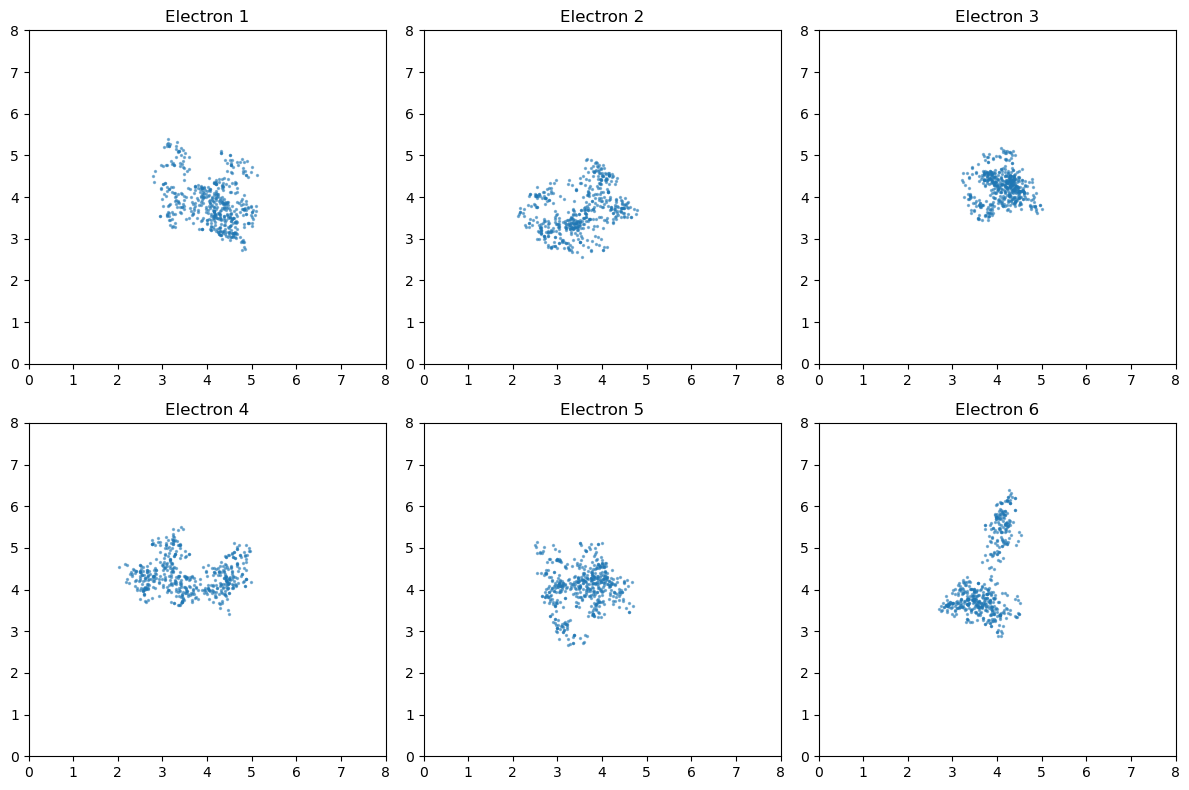

In [ ]:
# Reshape the sampled positions: positions shape should be (n_steps, N_e, 2)
positions = torch.stack(samples).cpu().numpy()  # (n_steps, N_e, 2)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # For N_e = 6: 2 rows, 3 cols
for i in range(N_e):
    ax = axes[i//3, i%3]
    ax.scatter(positions[:,i,0], positions[:,i,1], s=2, alpha=0.5)
    ax.set_xlim(0, L_test)
    ax.set_ylim(0, L_test)
    ax.set_title(f'Electron {i+1}')
plt.tight_layout()
plt.show()


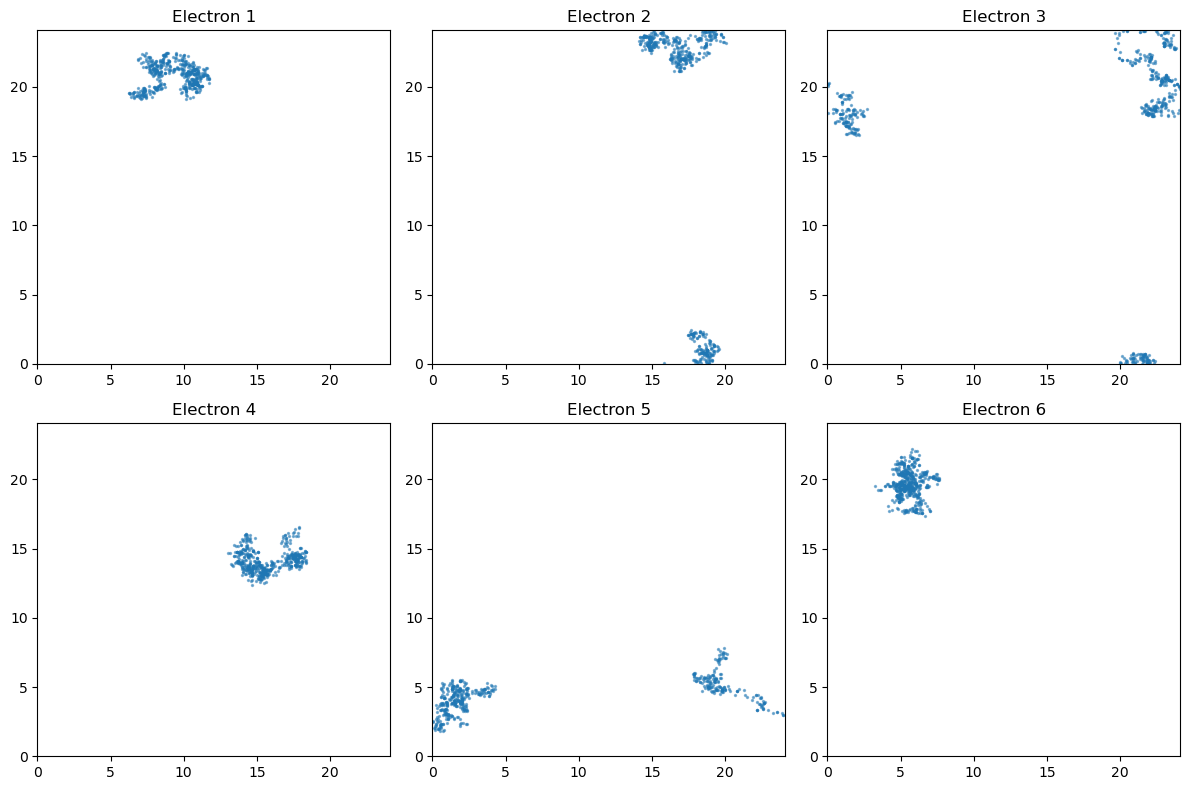

Acceptance ratio: 0.90


In [21]:
# check for my  actual SlaterNet code
n_steps = 500
step_size = 0.2  # You may need to lower this a lot if acceptance is near 0

# ---- Initialize your SlaterNet (assuming definition from before) ----
net = SlaterNet(a=a_m, N=N_e, L=32, num_layers=2).to('cpu')  # 'cpu' or 'cuda', depending on your setup

# ---- Initial electron configuration ----
R_init = torch.rand(N_e, 2) * L   # Or center, as before

# ---- Run the sampler ----
samples = mcmc_sampler(net, R_init, n_steps=n_steps, step_size=step_size)

# ---- Gather samples for plotting ----
positions = torch.stack(samples).cpu().numpy()   # (n_steps, N_e, 2)

# ---- Plot each electron's samples ----
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i in range(N_e):
    ax = axes[i//3, i%3]
    ax.scatter(positions[:,i,0], positions[:,i,1], s=2, alpha=0.5)
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_title(f'Electron {i+1}')
plt.tight_layout()
plt.show()

# ---- Print acceptance ratio ----
accepted = 0
R = R_init.clone()
psi_sq = abs(net(R))**2
for step in range(n_steps):
    for i in range(N_e):
        R_prop = R.clone()
        R_prop[i] += step_size * torch.randn_like(R[i])
        R_prop[i] = R_prop[i] % L
        psi_sq_prop = abs(net(R_prop))**2
        if (psi_sq_prop / (psi_sq + 1e-12)) > torch.rand(1):
            accepted += 1
            R[i] = R_prop[i]
            psi_sq = psi_sq_prop
acceptance_ratio = accepted / (n_steps * N_e)
print(f"Acceptance ratio: {acceptance_ratio:.2f}")

# Result is expected for a randomly initialized (untrained) SlaterNet!
# Electrons get “stuck” in random clusters—these are just “blobs” where the random neural network happens to give a non-tiny value.
# There is no physics yet: This is expected until you train the net with your VMC routine!

Compare two ways of calculating Local Energy, check both energy and time it takes:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === 1) Original (nested‐loop) Laplacian for comparison ===

def complex_grad_orig(outputs, inputs, grad_outputs=None):
    """Compute ∇(outputs) via two backward passes (real and imag)."""
    grad_real = torch.autograd.grad(
        outputs.real, inputs, grad_outputs=grad_outputs,
        create_graph=True, allow_unused=True
    )[0]
    grad_imag = torch.autograd.grad(
        outputs.imag, inputs, grad_outputs=grad_outputs,
        create_graph=True, allow_unused=True
    )[0]

    if grad_real is not None and grad_imag is not None:
        return grad_real + 1j * grad_imag
    elif grad_real is not None:
        return grad_real
    elif grad_imag is not None:
        return 1j * grad_imag
    else:
        return torch.zeros_like(inputs)

def compute_laplacian_orig(psi, R):
    """
    Compute ∇²ψ by looping over electrons i and dims d,
    calling complex_grad_orig(...) on each first derivative.
    """
    grads = complex_grad_orig(psi, R)    # shape (N_e, D), complex
    lap = 0 + 0j
    N, D = R.shape

    for i in range(N):
        for d in range(D):
            first_deriv = grads[i, d]             # ∂ψ/∂R_{i,d}
            grads2 = complex_grad_orig(first_deriv, R)
            lap += grads2[i, d]                   # accumulate ∂²ψ/∂R_{i,d}²

    return lap

def local_energy_orig(net, R):
    """
    “Original” local energy: 
      kinetic = -½ ∑_i (∇²ψ/ψ), plus a toy potential V = ∑_i |r_i|².
    """
    R = R.clone().detach().to(device).requires_grad_(True)
    psi = net(R)                                # complex scalar
    lap_psi = compute_laplacian_orig(psi, R)     # complex
    kin = -(hbar2_over_2m * (lap_psi / psi)).real    
    V_np = energy_static(R.detach().cpu().numpy())
    V = torch.tensor(V_np, device=device, dtype=kin.dtype)


    return kin + V

# === 2) Hessian‐based Laplacian (correct, and O((ND)²) memory—okay for small N_e) ===

def compute_laplacian_hessian(net, R):
    """
    Compute ∇²ψ(R) by taking the trace of the full Hessian
    of ψ's real and imag parts.
    """
    R = R.clone().detach().to(device).requires_grad_(True)

    # Define helper functions that output a real scalar:
    def fn_real(X):
        return net(X).real

    def fn_imag(X):
        return net(X).imag

    # Each Hessian has shape (N, D, N, D). Flatten to (ND, ND) for trace.
    H_real = torch.autograd.functional.hessian(fn_real, R)  # (N, D, N, D)
    H_imag = torch.autograd.functional.hessian(fn_imag, R)  # (N, D, N, D)

    N, D = R.shape
    H_real_flat = H_real.reshape(N*D, N*D)
    H_imag_flat = H_imag.reshape(N*D, N*D)

    lap_real = torch.trace(H_real_flat)
    lap_imag = torch.trace(H_imag_flat)
    return lap_real + 1j * lap_imag

def local_energy_hessian(net, R):
    """ Local energy using the Hessian‐based Laplacian."""
    
    R = R.clone().detach().to(device).requires_grad_(True)
    psi = net(R)  # complex scalar

    # The only change: use compute_laplacian_hessian instead of nested loops.
    lap_psi = compute_laplacian_hessian(net, R)  # complex

    denominator = psi if torch.abs(psi) > 1e-12 else psi + 1e-12  # avoid division by zero
    kin = -(hbar2_over_2m * (lap_psi / denominator)).real    
    # kin = -(hbar2_over_2m * (lap_psi / psi)).real    

    if torch.isnan(kin):
        print(f"[local_energy] NaN detected in kinetic: psi={psi}, lap_psi={lap_psi}, kin={kin}")

    V_np = energy_static(R.detach().cpu().numpy())
    V = torch.tensor(V_np, device=device, dtype=kin.dtype)
    total_energy = kin + V
    return total_energy


net = SlaterNet(a_m, N_e, L=64, num_layers=3).to(device) #-----number layers: 3; Perceptron dim: 64

# === 4) Compare on a random configuration ===
torch.manual_seed(4)  # Set the seed
R = torch.randn(N_e, 2, device=device)

E_orig = local_energy_orig(net, R)
E_hess = local_energy_hessian(net, R)

print(f"Original energy:   {E_orig.item():.12f}")
print(f"Hessian energy:    {E_hess.item():.12f}")
print(f"Difference:        {abs(E_orig - E_hess).item():.12e}")

Original energy:   659.026428222656
Hessian energy:    659.027221679688
Difference:        7.934570312500e-04


In [ ]:
# check the time

import time
_ = local_energy_orig(net, R)
_ = local_energy_hessian(net, R)

t0 = time.time()
E_orig = local_energy_orig(net, R)
t1 = time.time()
E_hess = local_energy_hessian(net, R)
t2 = time.time()

print(f"Original: {t1-t0:.5f} sec")
print(f"Hessian:  {t2-t1:.5f} sec")

Original: 0.03314 sec
Hessian:  0.01720 sec
